In [2]:
import sys
sys.path.append('../src/')

In [3]:
%load_ext autoreload
%autoreload 2
from inspector import load_model
from patch import patch_suppress_enhance

In [4]:
import os
import seaborn as sb
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

from val_utils import get_top_neurons

In [5]:
import seaborn as sb

In [5]:
def pred_true_labels(df, inspector):
    predicted_logits = []
    for text in df.text.to_list():
        encoded_input = inspector._prepare_inputs(text)
        output = inspector.model(**encoded_input)
        predicted_logits.append(output.logits.detach().cpu().numpy())
    predicted_labels = np.argmax(np.array(predicted_logits), axis=-1)[:, 0]
    true_labels = df.label.to_numpy()
    return predicted_labels, true_labels

In [6]:
data_path = "../data/input/"
EXPERIMENT_NAME = f"car_distance"  #car_distance_electoral_seeking
DATASET_NAME = "DAIGTV2"
BASE_MODEL_NAME = "bert-base-cased"
MODEL_DICT_ID = f"detector-{BASE_MODEL_NAME}-{DATASET_NAME}-{EXPERIMENT_NAME}"
random_state = 0
data_path

'../data/input/'

## Prepare data

In [8]:
data_input = os.path.join(data_path, "train_v2_drcat_02.csv")
daigt_df_all = pd.read_csv(data_input)

data_input = os.path.join(data_path, f"data_train_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.json")
daigt_train = pd.read_json(data_input, orient='records', lines=True)

train_idx = []
for i, text in enumerate(daigt_train.text):
    idx = np.where(daigt_train.text==text)[0]
    if len(idx)==1:
        train_idx.append(idx[0])
    else:
        print(i)
daigt_train.index = train_idx

TOPICS_ANALYSIS = list(daigt_train.prompt_name.unique())
print(TOPICS_ANALYSIS)

daigt_not_train = daigt_df_all[~daigt_df_all.index.isin(train_idx)].copy()

['Car-free cities', 'Distance learning']


In [9]:
daigt_test = daigt_not_train[daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test = daigt_test.loc[index_sample].copy()
daigt_test.shape

(1000, 5)

In [10]:
daigt_test_2 = daigt_not_train[~daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test_2.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
index_sample = daigt_test_2.groupby('label').sample(500, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
daigt_test_2.shape

(1000, 5)

In [11]:
#data_input = "/home/carloabrate/detect-interpret/data/input/train_v2_drcat_02.csv"
data_input = "../data/input/hc3_all.json"

hc3_all = pd.read_json(data_input, orient='records', lines=True)
hc3_all = hc3_all[hc3_all.text.apply(len)>10].copy()
index_sample = hc3_all.groupby('label').sample(500, random_state=random_state).index.tolist()
hc3_test = hc3_all.loc[index_sample].copy()
hc3_test.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [12]:
#data_input = "/home/carloabrate/detect-interpret/data/input/train_v2_drcat_02.csv"
data_input = "../data/input/xsum_gpt_eng.json"

xsum_gpt = pd.read_json(data_input, orient='records', lines=True)
xsum_gpt = xsum_gpt[xsum_gpt.text.apply(len)>10].copy()
index_sample = xsum_gpt.groupby('labels').sample(500, random_state=random_state).index.tolist()
xsum_gpt_test = xsum_gpt.loc[index_sample].copy()
xsum_gpt_test.labels.value_counts()

xsum_gpt_test.rename(columns={'labels':'label'}, inplace=True)

# Compute accuracy

In [13]:
n0, n1, top_neurons = get_top_neurons(500, EXPERIMENT_NAME, DATASET_NAME, random_state)

In [14]:
len(top_neurons)

138

In [15]:
top_neurons = [n[0] for n in top_neurons]

In [16]:
results_cm_all = []

In [17]:
inspector = load_model(f"../models/{MODEL_DICT_ID}/")
results_cm = [0]
# for df in [daigt_test, daigt_test_2, hc3_test]:
for df in [daigt_test_2, hc3_test, xsum_gpt_test]:
    y_pred, y_true = pred_true_labels(df, inspector)
    current_results = confusion_matrix(y_true, y_pred).flatten()
    results_cm.append(current_results)
    print(current_results)
results_cm_all.append(results_cm)

[436  64   4 496]
[279 221  18 482]
[361 139   6 494]


In [18]:
top_neurons_tot = list(np.arange(51))
pbar = tqdm(top_neurons_tot)
for i in pbar:
    inspector = load_model(f"../models/{MODEL_DICT_ID}/")
    patch_suppress_enhance(inspector.model, neurons=top_neurons[:i+1])
    results_cm = [i+1]
    for j, df in enumerate([daigt_test_2, hc3_test, xsum_gpt_test]):
        y_pred, y_true = pred_true_labels(df, inspector)
        current_results = confusion_matrix(y_true, y_pred).flatten()
        results_cm.append(current_results)
        pbar.set_description(f"i: {i}, neur: {top_neurons[i]}, df: {j}, metrics {current_results}")
    results_cm_all.append(results_cm)
    # print(top_neurons[i], results_cm)

i: 50, neur: (6, 1703), df: 2, metrics [397 103  12 488]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [41:35<00:00, 48.94s/it]


In [19]:
cm_df = pd.DataFrame([np.concatenate(x[1:]) for x in results_cm_all]).reset_index()

In [20]:
cm_df.columns = ['removed', 
                 'tp_oos', 'fp_oos', 'fn_oos', 'tn_oos',
                 'tp_ood', 'fp_ood', 'fn_ood', 'tn_ood',
                 'tp_xsum', 'fp_xsum', 'fn_xsum', 'tn_xsum',
                ]

In [21]:
cm_df['removed'] = [0]+top_neurons_tot

In [22]:
# cm_df['TNR_is'] = cm_df['tn_is']/(cm_df['tn_is']+cm_df['fp_is'])
cm_df['TNR_oos'] = cm_df['tn_oos']/(cm_df['tn_oos']+cm_df['fp_oos'])
cm_df['TNR_ood'] = cm_df['tn_ood']/(cm_df['tn_ood']+cm_df['fp_ood'])
cm_df['TNR_xsum'] = cm_df['tn_xsum']/(cm_df['tn_xsum']+cm_df['fp_xsum'])

In [23]:
cm_df['TPR_oos'] = cm_df['tp_oos']/(cm_df['tp_oos']+cm_df['fn_oos'])
cm_df['TPR_ood'] = cm_df['tp_ood']/(cm_df['tp_ood']+cm_df['fn_ood'])
cm_df['TPR_xsum'] = cm_df['tp_xsum']/(cm_df['tp_xsum']+cm_df['fn_xsum'])

In [24]:
cm_df['ACC_oos'] = (cm_df['tp_oos']+cm_df['tn_oos'])/(cm_df['tp_oos']+cm_df['tn_oos']+cm_df['fp_oos']+cm_df['fn_oos'])
cm_df['ACC_ood'] = (cm_df['tp_ood']+cm_df['tn_ood'])/(cm_df['tp_ood']+cm_df['tn_ood']+cm_df['fp_ood']+cm_df['fn_ood'])
cm_df['ACC_xsum'] = (cm_df['tp_xsum']+cm_df['tn_xsum'])/(cm_df['tp_xsum']+cm_df['tn_xsum']+cm_df['fp_xsum']+cm_df['fn_xsum'])

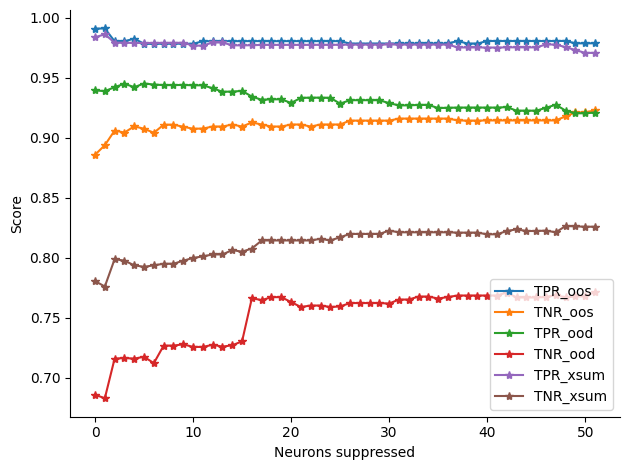

In [25]:
cm_df[['TPR_oos', 'TNR_oos', 'TPR_ood', 'TNR_ood', 'TPR_xsum', 'TNR_xsum']].plot(style='*-')
# plt.title(f"{EXPERIMENT_NAME} \n {TOPICS_ANALYSIS}")
plt.xlabel('Neurons suppressed')
plt.ylabel('Score')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/tpr_tnr_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")

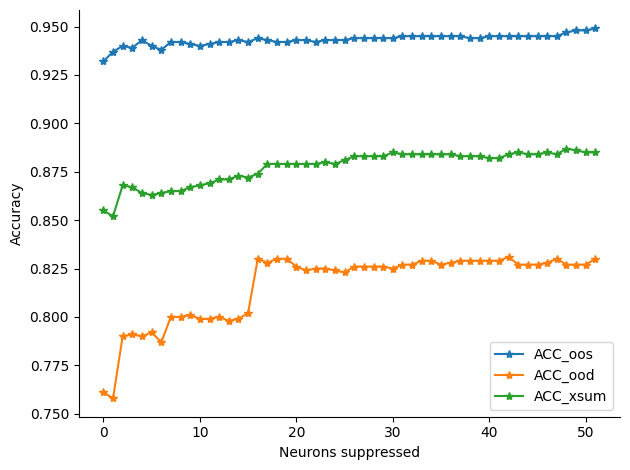

In [26]:
cm_df[['ACC_oos', 'ACC_ood', 'ACC_xsum']].plot(style='*-')
# plt.title(f"{EXPERIMENT_NAME} \n {TOPICS_ANALYSIS}")
plt.xlabel('Neurons suppressed')
plt.ylabel('Accuracy')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/accuracy_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")

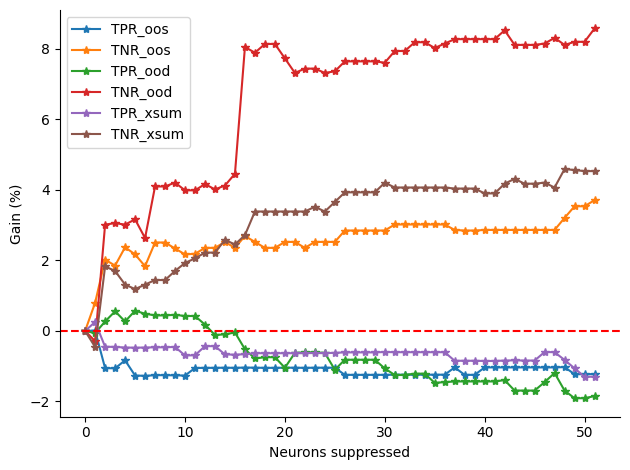

In [27]:
(100*(cm_df-cm_df.iloc[0])[['TPR_oos', 'TNR_oos', 'TPR_ood', 'TNR_ood', 'TPR_xsum', 'TNR_xsum']]).plot(style='*-')
plt.axhline(0., c='r', ls='--')
# plt.title(f"{EXPERIMENT_NAME} \n {TOPICS_ANALYSIS}")
plt.xlabel('Neurons suppressed')
plt.ylabel('Gain (%)')
plt.lab
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/tpr_tnr_gain_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")

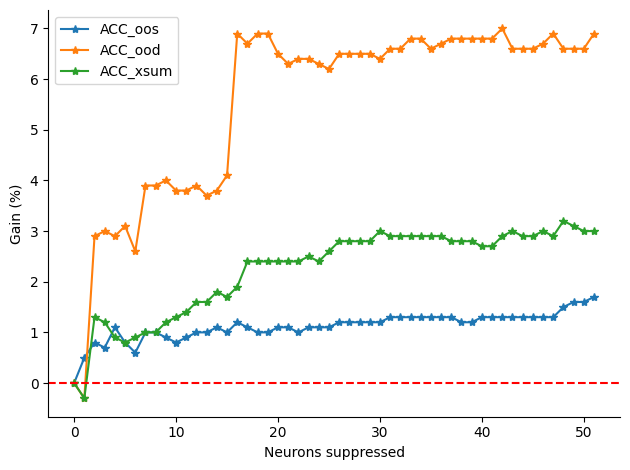

In [28]:
(100*(cm_df-cm_df.iloc[0])[['ACC_oos', 'ACC_ood', 'ACC_xsum']]).plot(style='*-')
plt.axhline(0., c='r', ls='--')
# plt.title(f"{EXPERIMENT_NAME} \n {TOPICS_ANALYSIS}")
plt.xlabel('Neurons suppressed')
plt.ylabel('Gain (%)')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/acc_gain_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")

In [29]:
cm_df['neurons'] = ["None"]+[top_neurons[i] for i in top_neurons_tot]

In [30]:
cm_df.iloc[1:, 0] += 1

In [31]:
cm_df.to_csv(f'../data/patching_scores_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.csv')

In [32]:
cm_df

,removed,tp_oos,fp_oos,fn_oos,tn_oos,tp_ood,fp_ood,fn_ood,tn_ood,tp_xsum,...,TNR_oos,TNR_ood,TNR_xsum,TPR_oos,TPR_ood,TPR_xsum,ACC_oos,ACC_ood,ACC_xsum,neurons
0,0,436,64,4,496,279,221,18,482,361,...,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855,None
1,1,441,59,4,496,276,224,18,482,357,...,0.893694,0.682720,0.775862,0.991011,0.938776,0.986188,0.937,0.758,0.852,"(1, 1880)"
2,2,449,51,9,491,309,191,19,481,376,...,0.905904,0.715774,0.798701,0.980349,0.942073,0.979167,0.940,0.790,0.868,"(2, 892)"
3,3,448,52,9,491,309,191,18,482,375,...,0.904236,0.716196,0.797407,0.980306,0.944954,0.979112,0.939,0.791,0.867,"(0, 2773)"
4,4,451,49,8,492,309,191,19,481,372,...,0.909427,0.715774,0.793548,0.982571,0.942073,0.978947,0.943,0.790,0.864,"(0, 2090)"
5,5,450,50,10,490,310,190,18,482,371,...,0.907407,0.717262,0.792271,0.978261,0.945122,0.978892,0.940,0.792,0.863,"(0, 2363)"
6,6,448,52,10,490,305,195,18,482,372,...,0.904059,0.711965,0.793548,0.978166,0.944272,0.978947,0.938,0.787,0.864,"(1, 2338)"
7,7,452,48,10,490,319,181,19,481,373,...,0.910781,0.726586,0.794830,0.978355,0.943787,0.979003,0.942,0.800,0.865,"(6, 2413)"
8,8,452,48,10,490,319,181,19,481,373,...,0.910781,0.726586,0.794830,0.978355,0.943787,0.979003,0.942,0.800,0.865,"(3, 1139)"
9,9,451,49,10,490,320,180,19,481,375,...,0.909091,0.727685,0.797407,0.978308,0.943953,0.979112,0.941,0.801,0.867,"(0, 2030)"


In [33]:
cm_df.neurons.tolist()

['None',
 (1, 1880),
 (2, 892),
 (0, 2773),
 (0, 2090),
 (0, 2363),
 (1, 2338),
 (6, 2413),
 (3, 1139),
 (0, 2030),
 (0, 1825),
 (8, 960),
 (0, 333),
 (0, 1849),
 (0, 1873),
 (1, 11),
 (3, 677),
 (0, 1714),
 (3, 2941),
 (6, 1232),
 (0, 661),
 (2, 50),
 (3, 2528),
 (6, 2569),
 (3, 934),
 (0, 2666),
 (0, 368),
 (0, 2048),
 (6, 883),
 (3, 1924),
 (2, 1772),
 (5, 1971),
 (3, 1262),
 (4, 768),
 (4, 1707),
 (3, 2964),
 (6, 1583),
 (3, 1692),
 (2, 362),
 (6, 2763),
 (6, 2570),
 (8, 2861),
 (9, 858),
 (1, 1179),
 (4, 1525),
 (3, 2346),
 (4, 1746),
 (0, 2487),
 (1, 865),
 (5, 348),
 (7, 1906),
 (6, 1703)]

# Random Baseline

In [38]:
np.random.seed(0)
rnd_layers = np.random.choice(np.arange(0, 12), size=50)
rnd_neurons = np.random.choice(np.arange(0, 3072), size=50)

In [39]:
rnd_neurons = [(l, n) for l, n in zip(rnd_layers, rnd_neurons)]

In [40]:
len(rnd_neurons)

50

In [69]:
results_cm_all = []

In [70]:
inspector = load_model(f"../models/{MODEL_DICT_ID}/")
results_cm = [0]
# for df in [daigt_test, daigt_test_2, hc3_test]:
for df in [daigt_test_2, hc3_test, xsum_gpt_test]:
    y_pred, y_true = pred_true_labels(df, inspector)
    current_results = confusion_matrix(y_true, y_pred).flatten()
    results_cm.append(current_results)
    print(current_results)
results_cm_all.append(results_cm)

[436  64   4 496]
[279 221  18 482]
[361 139   6 494]


In [71]:
top_neurons_tot = list(np.arange(50))

In [72]:
for counter in range(4):
    np.random.seed(counter)
    rnd_layers = np.random.choice(np.arange(0, 12), size=50)
    rnd_neurons = np.random.choice(np.arange(0, 3072), size=50)
    rnd_neurons = [(l, n) for l, n in zip(rnd_layers, rnd_neurons)]
    pbar = tqdm(top_neurons_tot)
    for i in pbar:
        inspector = load_model(f"../models/{MODEL_DICT_ID}/")
        patch_suppress_enhance(inspector.model, neurons=rnd_neurons[:i+1])
        results_cm = [i+1]
        for j, df in enumerate([daigt_test_2, hc3_test, xsum_gpt_test]):
            y_pred, y_true = pred_true_labels(df, inspector)
            current_results = confusion_matrix(y_true, y_pred).flatten()
            results_cm.append(current_results)
            pbar.set_description(f"i: {i}, neur: {rnd_neurons[i]}, df: {j}, metrics {current_results}")
        results_cm_all.append(results_cm)
        # print(top_neurons[i], results_cm)

i: 49, neur: (11, 1877), df: 2, metrics [355 145   5 495]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:14:10<00:00, 89.00s/it]
i: 49, neur: (4, 2197), df: 2, metrics [363 137   7 493]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:13:56<00:00, 88.73s/it]
i: 49, neur: (1, 1957), df: 2, metrics [359 141   6 494]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:06:24<00:00, 79.68s/it]
i: 49, neur: (0, 1712), df: 2, metrics [362 138   7 493]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:06:03<00:00, 79.26s/it]


In [73]:
cm_df = pd.DataFrame([np.concatenate(x[1:]) for x in results_cm_all]).reset_index()

In [74]:
cm_df.columns = ['removed', 
                 'tp_oos', 'fp_oos', 'fn_oos', 'tn_oos',
                 'tp_ood', 'fp_ood', 'fn_ood', 'tn_ood',
                 'tp_xsum', 'fp_xsum', 'fn_xsum', 'tn_xsum',
                ]

In [77]:
cm_df['removed'] = [0]+top_neurons_tot*4

In [78]:
# cm_df['TNR_is'] = cm_df['tn_is']/(cm_df['tn_is']+cm_df['fp_is'])
cm_df['TNR_oos'] = cm_df['tn_oos']/(cm_df['tn_oos']+cm_df['fp_oos'])
cm_df['TNR_ood'] = cm_df['tn_ood']/(cm_df['tn_ood']+cm_df['fp_ood'])
cm_df['TNR_xsum'] = cm_df['tn_xsum']/(cm_df['tn_xsum']+cm_df['fp_xsum'])

In [79]:
cm_df['TPR_oos'] = cm_df['tp_oos']/(cm_df['tp_oos']+cm_df['fn_oos'])
cm_df['TPR_ood'] = cm_df['tp_ood']/(cm_df['tp_ood']+cm_df['fn_ood'])
cm_df['TPR_xsum'] = cm_df['tp_xsum']/(cm_df['tp_xsum']+cm_df['fn_xsum'])

In [80]:
cm_df['ACC_oos'] = (cm_df['tp_oos']+cm_df['tn_oos'])/(cm_df['tp_oos']+cm_df['tn_oos']+cm_df['fp_oos']+cm_df['fn_oos'])
cm_df['ACC_ood'] = (cm_df['tp_ood']+cm_df['tn_ood'])/(cm_df['tp_ood']+cm_df['tn_ood']+cm_df['fp_ood']+cm_df['fn_ood'])
cm_df['ACC_xsum'] = (cm_df['tp_xsum']+cm_df['tn_xsum'])/(cm_df['tp_xsum']+cm_df['tn_xsum']+cm_df['fp_xsum']+cm_df['fn_xsum'])

In [81]:
cm_df

,removed,tp_oos,fp_oos,fn_oos,tn_oos,tp_ood,fp_ood,fn_ood,tn_ood,tp_xsum,...,tn_xsum,TNR_oos,TNR_ood,TNR_xsum,TPR_oos,TPR_ood,TPR_xsum,ACC_oos,ACC_ood,ACC_xsum
0,0,436,64,4,496,279,221,18,482,361,...,494,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855
1,0,436,64,4,496,279,221,18,482,361,...,494,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855
2,1,436,64,4,496,279,221,18,482,361,...,494,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855
3,2,436,64,4,496,279,221,18,482,361,...,494,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855
4,3,436,64,4,496,279,221,18,482,361,...,494,0.885714,0.685633,0.780411,0.990909,0.939394,0.983651,0.932,0.761,0.855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,45,437,63,5,495,280,220,18,482,362,...,493,0.887097,0.686610,0.781300,0.988688,0.939597,0.981030,0.932,0.762,0.855
197,46,437,63,5,495,280,220,18,482,362,...,493,0.887097,0.686610,0.781300,0.988688,0.939597,0.981030,0.932,0.762,0.855
198,47,437,63,6,494,280,220,18,482,362,...,493,0.886894,0.686610,0.781300,0.986456,0.939597,0.981030,0.931,0.762,0.855
199,48,436,64,5,495,281,219,18,482,362,...,493,0.885510,0.687589,0.781300,0.988662,0.939799,0.981030,0.931,0.763,0.855


In [83]:
cm_df.iloc[1:, 0] += 1

In [84]:
cm_df.to_csv(f'../data/patching_scores_rnd_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.csv')

In [86]:
gain_df = (100*(cm_df-cm_df.iloc[0])).copy()

<Axes: xlabel='removed', ylabel='ACC_oos'>

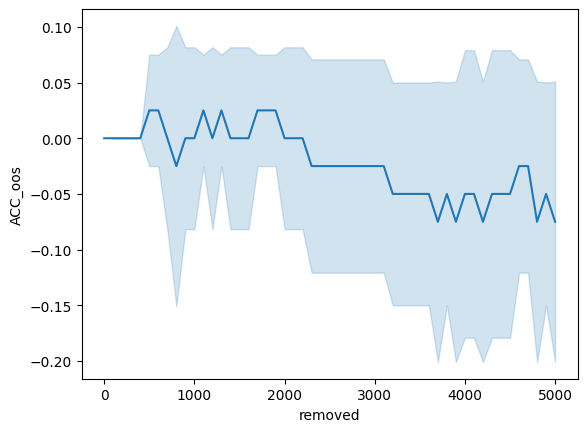

In [93]:
sb.lineplot(data=gain_df, x='removed', y='ACC_oos', errorbar=('sd', 1))